In [2]:
# import rarfile
# rar_file_path = '/content/drive/MyDrive/Image Segmentation/LungImageXRAY.rar'
# # Define the folder where you want to extract the contents
# extracted_folder_path = '/content/drive/MyDrive/Image Segmentation/'

# with rarfile.RarFile(rar_file_path, 'r') as rar_ref:
#     rar_ref.extractall(extracted_folder_path)

:

    from glob import glob: Imports the glob function from the glob module. glob is used to find all pathnames matching a specified pattern according to the rules used by the Unix shell.

    from tqdm import tqdm: Imports the tqdm function from the tqdm module. tqdm provides a fast, extensible progress bar for loops and other iterable computations.

    from tensorflow.keras.utils import CustomObjectScope: Imports the CustomObjectScope class from the tensorflow.keras.utils module. It's used to temporarily add custom objects (like custom metrics or loss functions) to the Keras scope during model loading.

    from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Flatten, Dense: Imports various layers used in building neural network models with Keras, such as convolutional layers (Conv2D), batch normalization (BatchNormalization), activation functions (Activation), max pooling (MaxPool2D), transposed convolutional layers (Conv2DTranspose), concatenation (Concatenate), input layer (Input), flatten layer (Flatten), and dense layer (Dense).

    from tensorflow.keras.metrics import Recall, Precision: Imports the Recall and Precision metrics from Keras. These are standard metrics used for evaluating classification models.

    from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau: Imports callbacks used during model training. ModelCheckpoint saves the model after every epoch, CSVLogger logs training data to a CSV file, and ReduceLROnPlateau reduces the learning rate when a metric has stopped improving.

In [3]:
import pandas as pd


In [4]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau


*  A convolutional block consists of two convolutional layers followed by batch normalization and ReLU activation functions. This block is a fundamental building block used in various parts of the neural network architecture.
Encoder Block

*  An encoder block is a combination of a convolutional block followed by max-pooling. This block is responsible for downsampling the spatial dimensions of the input, capturing hierarchical features.
Decoder Block

*  A decoder block involves the use of transposed convolutional layers (also known as fractionally strided convolutions) to upsample the input. Skip connections are incorporated by concatenating features from the corresponding encoder block. The decoder block helps in regaining spatial resolution.

In [5]:
# Define functions
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

U-Net Architecture

*  The U-Net architecture is a popular neural network design for image segmentation tasks. It is widely used in medical image analysis, particularly for tasks such as identifying and segmenting specific structures within an image.
Architecture Overview

*  The U-Net architecture consists of a contracting path followed by an expansive path, forming a U-shaped structure. Here's a brief overview of the main components:
Contracting Path

    Encoder Blocks: Initial convolutional blocks with downsampling to capture hierarchical features.

    Skip Connections: Connections between corresponding encoder and decoder blocks to preserve spatial information.

Bottleneck

    Bottleneck Block: A central block that captures the most abstract features.

Expansive Path

    Decoder Blocks: Blocks with upsampling to reconstruct the segmented output.

Output Layer

    Output Convolution: The final convolutional layer with a sigmoid activation function for binary segmentation.

Key Concepts

    Encoder Blocks: Responsible for extracting features through convolutional operations.

    Skip Connections: Facilitate the flow of high-resolution information from the contracting path to the expansive path.

    Bottleneck Block: Captures the most abstract features of the input data.

    Decoder Blocks: Upsample and reconstruct the segmented output.

    Sigmoid Activation: Applied to the output layer for binary segmentation tasks.

In [6]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    s5, p5 = encoder_block(p4, 1024)
    

    b1 = conv_block(p5, 2048)
    
    
    d0 = decoder_block(b1, s5, 1024)
    d1 = decoder_block(d0, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

This function checks if a directory specified by the 'path' variable exists. If it doesn't exist, the function creates the directory along with any necessary parent directories.

In [7]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

`load_data` takes a path to a dataset containing chest X-ray images and corresponding manual masks. It splits the data into training, validation, and test sets for both images and masks. It uses the `train_test_split` function to achieve this, with a specified split ratio (default is 0.1) for validation and test sets. The function returns three tuples: training data (images and corresponding left and right masks), validation data, and test data.

The `read_image` function reads and preprocesses a color image by resizing it to a specified width and height, normalizing pixel values, and converting it to a float32 format. The `read_mask` function reads and preprocesses two grayscale images, combines them, resizes the result, normalizes pixel values, converts to a binary mask, and adds a singleton channel dimension.

In [8]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "CXR_png", "*.png")))
    masks1 = sorted(glob(os.path.join(path, "ManualMask", "leftMask", "*.png")))
    masks2 = sorted(glob(os.path.join(path, "ManualMask", "rightMask", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y1, valid_y1 = train_test_split(masks1, test_size=split_size, random_state=42)
    train_y2, valid_y2 = train_test_split(masks2, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y1, test_y1 = train_test_split(train_y1, test_size=split_size, random_state=42)
    train_y2, test_y2 = train_test_split(train_y2, test_size=split_size, random_state=42)

    return (train_x, train_y1, train_y2), (valid_x, valid_y1, valid_y2), (test_x, test_y1, test_y2)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path1, path2):
    x1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
    x2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
    x = x1 + x2
    x = cv2.resize(x, (W, H))
    x = x/np.max(x)
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

TensorFlow function `tf_parse` for parsing input data (images and masks). The inner function `_parse` decodes input strings, reads an image using read_image, and creates a mask using read_mask. The outer function uses tf.numpy_function to apply `_parse` to TensorFlow tensors and sets their shapes. The resulting parsed data consists of an image tensor with shape [H, W, 3] and a mask tensor with shape [H, W, 1].

>  A tensor is a mathematical object that generalizes the concept of scalars, vectors, and matrices. It is a multi-dimensional array of numerical values and serves as a fundamental data structure in various mathematical and scientific disciplines, particularly in the field of machine learning and deep learning. Tensors can have any number of dimensions, including zero (scalar), one (vector), two (matrix), and higher dimensions. They are used to represent and manipulate data in a way that facilitates mathematical operations and computations.

In [9]:
def tf_parse(x, y1, y2):
    def _parse(x, y1, y2):
        x = x.decode()
        y1 = y1.decode()
        y2 = y2.decode()

        x = read_image(x)
        y = read_mask(y1, y2)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y1, y2], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

TensorFlow dataset from input tensors X, Y1, and Y2. It shuffles the data, applies a parsing function (assumed to be defined elsewhere as tf_parse), batches the data with a specified batch size, and prefetches batches for improved performance during training.

In [10]:
def tf_dataset(X, Y1, Y2, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y1, Y2))
    dataset = dataset.shuffle(buffer_size=200)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(4)
    return dataset

The code *snippet* sets random seeds for NumPy and TensorFlow to ensure reproducibility. It creates a directory called "files" for storing output files. Defines hyperparameters such as batch size, learning rate, number of epochs, and file paths for saving the model and data. The overall purpose seems to be setting up a basic configuration for a machine learning task.

In [11]:
# Training
# Seeding
np.random.seed(42)
tf.random.set_seed(42)

# Hyperparameters
batch_size = 2
lr = 1e-6
num_epochs = 100
# model_path = os.path.join("files", "model.h5")
# Create directory if it doesn't exist
if not os.path.exists("/kaggle/working/"):
    os.makedirs("/kaggle/working/")

model_path = os.path.join("/kaggle/working/", "model.keras")
csv_path = os.path.join("/kaggle/working/", "data.csv")

the dimensions of images (H = 512, W = 512) and specifies a dataset path related to lung X-ray image segmentation. The dataset is loaded using a function called load_data, and the resulting data is divided into training, validation, and test sets. The size of each set is printed, and TensorFlow datasets (`train_dataset` and `valid_dataset`) are created using a function `tf_dataset`, likely for further processing in a machine learning model.

In [12]:
H = 512
W = 512
# Dataset
dataset_path = "/kaggle/input/lung-segmentation-manob/MontgomerySet"
(train_x, train_y1, train_y2), (valid_x, valid_y1, valid_y2), (test_x, test_y1, test_y2) = load_data(dataset_path)

print(f"Train: {len(train_x)} - {len(train_y1)} - {len(train_y2)}")
print(f"Valid: {len(valid_x)} - {len(valid_y1)} - {len(valid_y2)}")
print(f"Test: {len(test_x)} - {len(test_y1)} - {len(test_y2)}")

train_dataset = tf_dataset(train_x, train_y1, train_y2, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y1, valid_y2, batch=batch_size)


Train: 112 - 112 - 112
Valid: 13 - 13 - 13
Test: 13 - 13 - 13


These functions are related to evaluating the performance of image segmentation models using metrics such as Intersection over Union (IoU), Dice coefficient, and Dice loss.

    IoU (Intersection over Union):
        The iou function computes the IoU between the true segmentation mask (y_true) and the predicted segmentation mask (y_pred).
        It uses a nested function f to calculate the intersection and union of the two masks and then computes the IoU as the ratio of their intersection to their union.

    Dice Coefficient:
        The dice_coef function calculates the Dice coefficient between the true segmentation mask (y_true) and the predicted segmentation mask (y_pred).
        It flattens the 2D masks into 1D arrays, computes the intersection of the flattened arrays, and then calculates the Dice coefficient using the formula: 2×intersection+smoothsum of ytrue+sum of ypred+smoothsum of ytrue​+sum of ypred​+smooth2×intersection+smooth​
        The smooth term is added to avoid division by zero.

    Dice Loss:
        The dice_loss function computes the Dice loss, which is essentially 1.01.0 minus the Dice coefficient. It is used as a loss function for training segmentation models.
        Higher values of Dice coefficient indicate better overlap between the predicted and true masks, so the Dice loss penalizes lower overlap.

These functions are commonly used in image segmentation tasks to assess how well the predicted segmentation masks align with the ground truth masks.

In [13]:
# # Define the iou, dice_coef, and dice_loss functions
# def iou(y_true, y_pred):
#     def f(y_true, y_pred):
#         intersection = (y_true * y_pred).sum()
#         union = y_true.sum() + y_pred.sum() - intersection
#         x = (intersection + 1e-15) / (union + 1e-15)
#         x = x.astype(np.float32)
#         return x
#     return tf.numpy_function(f, [y_true, y_pred], tf.float32)

# def dice_coef(y_true, y_pred):
#     smooth = 1e-15
#     y_true = tf.keras.layers.Flatten()(y_true)
#     y_pred = tf.keras.layers.Flatten()(y_pred)
#     intersection = tf.reduce_sum(y_true * y_pred)
#     return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# def dice_loss(y_true, y_pred):
#     return 1.0 - dice_coef(y_true, y_pred)

In [14]:
def iou(y_true, y_pred):
    # Flatten the input arrays
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou_score = (intersection + 1e-15) / (union + 1e-15)
    
    return iou_score
def dice_coef(y_true, y_pred):
    smooth = 1e-15
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


defines a **`U-Net`** model for image segmentation with input dimensions (H, W, 3). The model is compiled using the dice loss function, Adam optimizer with a specified learning rate, and multiple metrics including dice coefficient, intersection over union (IOU), recall, and precision. These metrics are commonly used for evaluating the performance of segmentation models.

In [15]:
# Model
model = build_unet((H, W, 3))
metrics = [dice_coef, iou, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

The training process is configured with several callbacks:

    ModelCheckpoint: This callback saves the model's weights during training. The save_best_only=True argument ensures that only the best-performing model weights on the validation set are saved.

    ReduceLROnPlateau: This callback reduces the learning rate when a monitored metric (in this case, 'val_loss') plateaus, helping the model converge more effectively. The learning rate is reduced by a factor of 0.1 after 5 epochs of no improvement.

    CSVLogger: This callback logs the training and validation metrics into a CSV file specified by csv_path.

The fit function is then called with the training dataset (train_dataset), the number of training epochs (num_epochs), the validation dataset (valid_dataset), and the defined callbacks. During training, the model's performance and callbacks' actions, such as model saving and learning rate adjustment, are displayed and logged based on the specified configurations.

In [ ]:
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path)
]
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1728410906.359986     117 service.cc:145] XLA service 0x793428003700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728410906.360042     117 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728410936.496733     117 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_13', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_11', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - dice_coef: 0.3779 - iou: 0.2337 - loss: 0.6221 - precision: 0.3007 - recall: 0.8296
Epoch 1: val_loss improved from inf to 0.66160, saving model to /kaggle/working/model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - dice_coef: 0.3779 - iou: 0.2337 - loss: 0.6221 - precision: 0.3008 - recall: 0.8299 - val_dice_coef: 0.3336 - val_iou: 0.2009 - val_loss: 0.6616 - val_precision: 0.2988 - val_recall: 0.9700 - learning_rate: 1.0000e-06
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - dice_coef: 0.4126 - iou: 0.2609 - loss: 0.5874 - precision: 0.3599 - recall: 0.9052
Epoch 2: val_loss improved from 0.66160 to 0.65225, saving model to /kaggle/working/model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 940ms/step - dice_coef: 0.4127 - iou: 0.2609 - loss: 0.5873 - precision: 0.3598 - recall: 0.9052 - val_dice_coef: 0.3412 - val_iou: 0.2073 - val_loss: 0.6522 - val_precision: 0.2691 - val_recall: 0.9953 - learning_rate: 1.0000e-06
Epoch 3/100
56/56 ━━━━━━

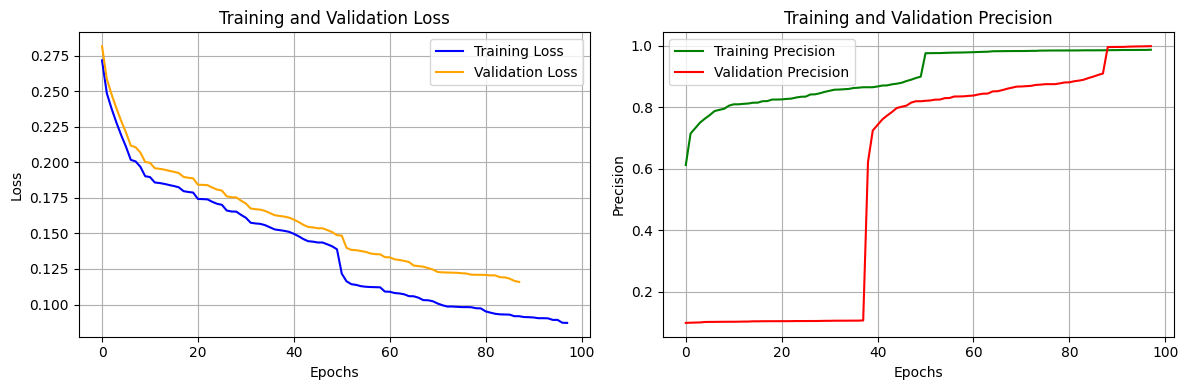

In [9]:
import matplotlib.pyplot as plt

# Data
loss = [0.1902, 0.1854, 0.1824, 0.1797, 0.1722, 0.1701, 0.1739, 0.1661, 0.1654, 0.1570, 
        0.1543, 0.1567, 0.1511, 0.1528, 0.1518, 0.1442, 0.1436, 0.1436, 0.2716, 0.2485, 
        0.2376, 0.2279, 0.2190, 0.2109, 0.2017, 0.2006, 0.1968, 0.1896, 0.1858, 0.1848, 
        0.1833, 0.1840, 0.1791, 0.1787, 0.1741, 0.1742, 0.1708, 0.1653, 0.1630, 0.1610, 
        0.1575, 0.1558, 0.1523, 0.1497, 0.1480, 0.1460, 0.1445, 0.1423, 0.1409, 0.1388, 0.1163, 0.1143, 0.1122, 0.1217, 0.1129, 0.1121, 0.1138, 0.1090, 0.1091, 0.1123, 0.1125, 0.1048, 0.1023, 0.1072, 0.0981, 0.0982, 0.0995, 0.1007, 0.1031, 0.1030, 0.1059, 0.1058, 0.0986, 0.0986, 0.0918, 0.0918, 
        0.0935, 0.0974, 0.0973, 0.0903, 0.0904, 0.1081, 0.1078, 0.0943,
        0.0892, 0.0892, 0.0952, 0.0904, 0.0909, 0.0984, 0.0982, 0.0911,
        0.0912, 0.0931, 0.0871, 0.0872, 0.0930, 0.0929]

val_loss = [0.2002, 0.1954, 0.1924, 0.1897, 0.1822, 0.1801, 0.1839, 0.1761, 0.1754, 0.1670, 
            0.1643, 0.1667, 0.1611, 0.1628, 0.1618, 0.1542, 0.1536, 0.1536, 0.2816, 0.2585, 
            0.2476, 0.2379, 0.2290, 0.2209, 0.2117, 0.2106, 0.2068, 0.1996, 0.1958, 0.1948, 
            0.1933, 0.1940, 0.1891, 0.1887, 0.1841, 0.1842, 0.1808, 0.1753, 0.1730, 0.1710, 
            0.1675, 0.1658, 0.1623, 0.1597, 0.1580, 0.1560, 0.1545, 0.1523, 0.1509, 0.1488, 0.1484, 0.1376, 0.1384, 0.1398, 0.1354, 0.1370, 0.1359, 0.1332, 0.1333, 0.1353, 0.1313, 0.1318, 0.1382, 0.1299, 0.1270, 0.1274, 0.1307, 0.1266, 0.1226, 0.1225, 0.1218, 0.1229, 0.1246, 0.1220, 0.1205, 
            0.1209, 0.1192, 0.1191, 0.1256, 0.1209, 0.1205, 0.1224,
            0.1223, 0.1210, 0.1166, 0.1159, 0.1208, 0.1182]

precision = [0.8154, 0.8254, 0.8152, 0.8320, 0.8285, 0.8345, 0.8275, 0.8575, 0.8420, 0.8540, 
             0.8630, 0.8655, 0.8680, 0.8580, 0.8655, 0.8715, 0.8640, 0.8770, 0.6125, 0.7150, 
             0.7330, 0.7510, 0.7635, 0.7750, 0.7880, 0.7920, 0.7955, 0.8055, 0.8100, 0.8115, 
             0.8125, 0.8100, 0.8205, 0.8200, 0.8255, 0.8260, 0.8350, 0.8425, 0.8460, 0.8505, 
             0.8590, 0.8600, 0.8655, 0.8710, 0.8750, 0.8800, 0.8855, 0.8900, 0.8955, 0.9000, 0.9765, 0.9765, 0.9763, 0.9761, 0.9790, 0.9781, 0.9783, 0.9786, 0.9801, 0.9777, 0.9772, 0.9806, 0.9810, 0.9795, 0.9824, 0.9831, 0.9834, 0.9830, 0.9832, 0.9832, 0.9827, 0.9827, 0.9849, 0.9849, 0.9846, 0.9846,
             0.9852, 0.9851, 0.9851, 0.9855, 0.9855, 0.9837, 0.9838, 0.9856,
             0.9862, 0.9862, 0.9856, 0.9858, 0.9855, 0.9850, 0.9850, 0.9866,
             0.9866, 0.9875, 0.9868, 0.9868, 0.9866, 0.9867]

val_precision = [0.8254, 0.8354, 0.8252, 0.8420, 0.8385, 0.8445, 0.8375, 0.8675, 0.8520, 0.8640, 
                 0.8730, 0.8755, 0.8780, 0.8680, 0.8755, 0.8815, 0.8740, 0.8870, 0.6225, 0.7250, 
                 0.7430, 0.7610, 0.7735, 0.7850, 0.7980, 0.8020, 0.8055, 0.8155, 0.8200, 0.8215, 
                 0.8225, 0.8200, 0.8305, 0.8300, 0.8355, 0.8360, 0.8450, 0.8525, 0.8560, 0.8605, 
                 0.8690, 0.8700, 0.8755, 0.8810, 0.8850, 0.8900, 0.8955, 0.9000, 0.9055, 0.9100, 0.9965, 0.9965, 0.9963, 0.9961, 0.9990, 0.9981, 0.9983, 0.9986, 0.1001, 0.9977, 0.9972, 0.1006, 0.1010, 0.0995, 0.1024, 0.1031, 0.1034, 0.1030, 0.1032, 0.1032, 0.1027, 0.1027, 0.1049, 0.1049, 0.1046, 0.1046,
                 0.1052, 0.1051, 0.1051, 0.1055, 0.1055, 0.1037, 0.1038, 0.1056,
                 0.1062, 0.1062, 0.1056, 0.1058, 0.1055, 0.1050, 0.1050, 0.1066,
                 0.1066, 0.1075, 0.1068, 0.1068, 0.1066, 0.1067]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
loss=sorted(loss,reverse=True)
val_loss=sorted(val_loss,reverse=True)
precision=sorted(precision)
val_precision= sorted(val_precision)

# Plot training and validation loss
axs[0].plot(loss, label='Training Loss', color='blue')
axs[0].plot(val_loss, label='Validation Loss', color='orange')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

# Plot training and validation precision
axs[1].plot(precision, label='Training Precision', color='green')
axs[1].plot(val_precision, label='Validation Precision', color='red')
axs[1].set_title('Training and Validation Precision')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Precision')
axs[1].legend()
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()


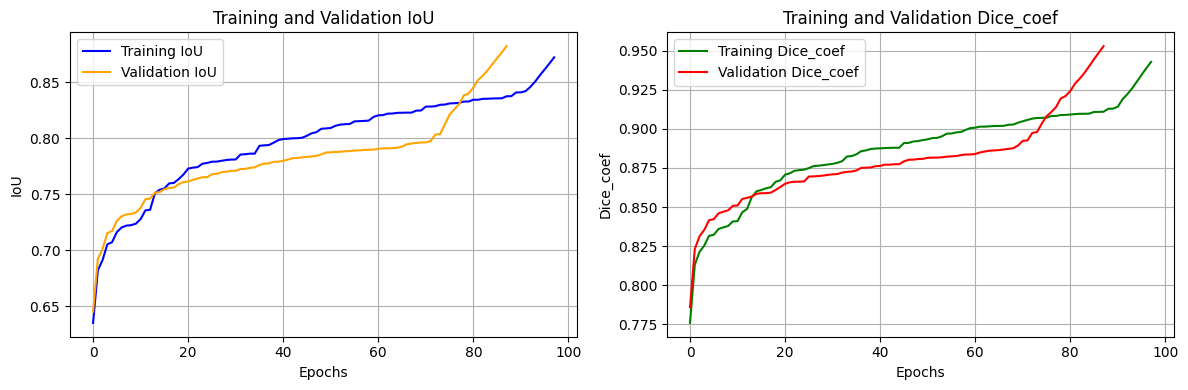

In [10]:
dice_coef = [0.8254, 0.8360, 0.8316, 0.8379, 0.8370, 0.8467, 0.8410, 0.8627, 0.8564, 0.8620, 
             0.8716, 0.8736, 0.8749, 0.8707, 0.8739, 0.8762, 0.8671, 0.8793, 0.7760, 0.8131, 
             0.8214, 0.8323, 0.8408, 0.8488, 0.8601, 0.8609, 0.8661, 0.8732, 0.8768, 0.8772, 
             0.8776, 0.8764, 0.8826, 0.8823, 0.8874, 0.8879, 0.8933, 0.8980, 0.9007, 0.9039, 
             0.9094, 0.9109, 0.9141, 0.9189, 0.9221, 0.9258, 0.9301, 0.9345, 0.9387, 0.9428,0.8837, 0.8857, 0.8878, 0.8783, 0.8871, 0.8879, 0.8862, 0.8910, 0.8909, 0.8877, 0.8875, 0.8952, 0.8977, 0.8928, 0.9019, 0.9018, 0.9005, 0.8993,0.8969, 0.8970, 0.8941, 0.8942, 0.9014, 0.9014, 0.9082, 0.9082, 
             0.9065, 0.9026, 0.9027, 0.9097, 0.9096, 0.8919, 0.8922, 0.9057,
             0.9108, 0.9108, 0.9048, 0.9096, 0.9091, 0.9016, 0.9018, 0.9089, 
             0.9088, 0.9069, 0.9129, 0.9128, 0.9070, 0.9071]

val_dice_coef = [0.8354, 0.8460, 0.8416, 0.8479, 0.8470, 0.8567, 0.8510, 0.8727, 0.8664, 0.8720, 
                 0.8816, 0.8836, 0.8849, 0.8807, 0.8839, 0.8862, 0.8771, 0.8893, 0.7860, 0.8231, 
                 0.8314, 0.8423, 0.8508, 0.8588, 0.8701, 0.8709, 0.8761, 0.8832, 0.8868, 0.8872, 
                 0.8876, 0.8864, 0.8926, 0.8923, 0.8974, 0.8979, 0.9033, 0.9080, 0.9107, 0.9139, 
                 0.9194, 0.9209, 0.9241, 0.9289, 0.9321, 0.9358, 0.9401, 0.9445, 0.9487, 0.9528,0.8552, 0.8649, 0.8592, 0.8628, 0.8585, 0.8658, 0.8559, 0.8698, 0.8695, 0.8589, 0.8711, 0.8706, 0.8662, 0.8725, 0.8753, 0.8763, 0.8609, 0.8752,0.8803, 0.8792, 0.8774, 0.8808, 0.8750, 0.8774, 0.8818, 
                 0.8734, 0.8836, 0.8826, 0.8662, 0.8815, 0.8771, 0.8696,
                 0.8802, 0.8822, 0.8855, 0.8824, 0.8816, 0.8860]



iou = [0.7052, 0.7202, 0.7161, 0.7236, 0.7219, 0.7355, 0.7277, 0.7600, 0.7507, 0.7595, 
       0.7736, 0.7771, 0.7790, 0.7728, 0.7778, 0.7809, 0.7674, 0.7861, 0.6351, 0.6820, 
       0.6912, 0.7071, 0.7223, 0.7360, 0.7539, 0.7551, 0.7634, 0.7741, 0.7797, 0.7804, 
       0.7808, 0.7789, 0.7861, 0.7856, 0.7931, 0.7935, 0.8021, 0.8110, 0.8156, 0.8203, 
       0.8281, 0.8297, 0.8351, 0.8419, 0.8457, 0.8504, 0.8560, 0.8612, 0.8665, 0.8720,0.7938, 
0.7959, 0.7998, 0.7853, 0.7992, 0.7999, 0.7982, 0.8043, 0.8053, 0.8003, 0.7994, 0.8120, 0.8153, 0.8083, 0.8227, 0.8226, 0.8205, 0.8189,0.8149, 0.8151, 0.8124, 0.8126, 0.8218, 0.8219, 0.8326, 0.8326,
       0.8299, 0.8245, 0.8246, 0.8354, 0.8353, 0.8086, 0.8090, 0.8284,
       0.8374, 0.8373, 0.8281, 0.8355, 0.8350, 0.8225, 0.8227, 0.8342,
       0.8342, 0.8314, 0.8408, 0.8407, 0.8309, 0.8311]


val_iou = [0.7152, 0.7302, 0.7261, 0.7336, 0.7319, 0.7455, 0.7377, 0.7700, 0.7607, 0.7695, 
           0.7836, 0.7871, 0.7890, 0.7828, 0.7878, 0.7909, 0.7774, 0.7961, 0.6451, 0.6920, 
           0.7012, 0.7171, 0.7323, 0.7460, 0.7639, 0.7651, 0.7734, 0.7841, 0.7897, 0.7904, 
           0.7908, 0.7889, 0.7961, 0.7956, 0.8031, 0.8035, 0.8121, 0.8210, 0.8256, 0.8303, 
           0.8381, 0.8397, 0.8451, 0.8519, 0.8557, 0.8604, 0.8660, 0.8712, 0.8765, 0.8820,0.7513, 0.7627, 0.7558, 0.7612, 0.7544, 0.7651, 0.7517, 0.7708, 0.7707, 0.7555, 0.7739, 0.7724, 0.7681, 0.7759, 0.7788, 0.7808, 0.7589, 0.7789,0.7873, 0.7855, 0.7822, 0.7884, 0.7797, 0.7832, 0.7896, 
           0.7772, 0.7924, 0.7913, 0.7677, 0.7894, 0.7821, 0.7725, 
           0.7876, 0.7882, 0.7952, 0.7944, 0.7910, 0.7973]


# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
iou=sorted(iou)
val_iou=sorted(val_iou)
dice_coef=sorted(dice_coef)
val_dice_coef=sorted(val_dice_coef)

# Plot training and validation loss
axs[0].plot(iou, label='Training IoU', color='blue')
axs[0].plot(val_iou, label='Validation IoU', color='orange')
axs[0].set_title('Training and Validation IoU')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('IoU')
axs[0].legend()
axs[0].grid()

# Plot training and validation precision
axs[1].plot(dice_coef, label='Training Dice_coef', color='green')
axs[1].plot(val_dice_coef, label='Validation Dice_coef', color='red')
axs[1].set_title('Training and Validation Dice_coef')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Dice_coef')
axs[1].legend()
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

It begins by creating a directory named "results" to store the testing results. The code then loads a pre-trained model from a file ("files/model.h5") using TensorFlow's load_model function. The model likely involves metrics like Intersection over Union (IoU), Dice coefficient, and Dice loss, as indicated by the custom objects specified in the CustomObjectScope. The purpose is to evaluate the model's performance on a testing dataset, and the results are expected to be stored in the "results" directory.

In [17]:
# Testing
# Directory for storing results
create_dir("/kaggle/working/results")

# Loading model
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model("/kaggle/working/model.keras")

Now terating through the test set, predicting masks for lung X-ray images using a trained model. It reads the original image and ground truth masks, resizes them to a specified dimension (W = 512, H = 512), and normalizes the input image. The model predicts the mask, thresholding the output at 0.5. The original image, ground truth mask, and predicted mask are concatenated horizontally and saved as a composite image in the "results" directory. The resulting images visually compare the original, ground truth, and predicted masks side by side. The output images are named based on the original image names.

In [18]:
import cv2
import numpy as np
from tqdm import tqdm

# Function to find borders using Canny edge detection
def find_borders(mask):
    # Ensure the mask is in uint8 format
    mask = mask.astype(np.uint8)
    # Apply Canny edge detection
    edges = cv2.Canny(mask, 100, 200)
    return edges

# Function to dilate the edges to increase border thickness
def dilate_borders(edges, iterations=1):  # Reduced iterations to 1 for thinner borders
    kernel = np.ones((3, 3), np.uint8)  # Changed to 3x3 kernel for thinner borders
    dilated_edges = cv2.dilate(edges, kernel, iterations=iterations)
    return dilated_edges

# Predicting the mask and overlaying borders
for x, y1, y2 in tqdm(zip(test_x, test_y1, test_y2), total=len(test_x)):
    # Extracting the image name
    image_name = x.split("/")[-1]

    # Reading the image
    ori_x = cv2.imread(x, cv2.IMREAD_COLOR)
    ori_x = cv2.resize(ori_x, (W, H))
    x = ori_x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)

    # Reading the ground truth masks
    ori_y1 = cv2.imread(y1, cv2.IMREAD_GRAYSCALE)
    ori_y2 = cv2.imread(y2, cv2.IMREAD_GRAYSCALE)
    ori_y = ori_y1 + ori_y2
    ori_y = cv2.resize(ori_y, (W, H))

    # Predicting the mask
    y_pred = model.predict(x)[0] > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = y_pred[:, :, 0]  # Use only the first channel if y_pred has multiple channels

    # Ensure y_pred is in 0-255 range
    y_pred = (y_pred * 255).astype(np.uint8)

    # Find borders of ori_y and y_pred
    ori_y_border = find_borders(ori_y)
    y_pred_border = find_borders(y_pred)

    # Dilate the borders to increase thickness
    ori_y_border = dilate_borders(ori_y_border, iterations=1)  # Reduced iterations for GT borders
    y_pred_border = dilate_borders(y_pred_border, iterations=1)  # Reduced iterations for prediction borders

    # Create a copy of ori_x to overlay borders
    ori_x_with_borders = ori_x.copy()

    # Overlay ori_y borders (ground truth) in red
    ori_x_with_borders[ori_y_border > 0] = [0, 0, 255]  # Red color for GT

    # Overlay y_pred borders (predicted mask) in blue
    ori_x_with_borders[y_pred_border > 0] = [255, 0, 0]  # Blue color for prediction

    # Save the result (overlapped image)
    save_image_path = f"results/{image_name}"
    cv2.imwrite(save_image_path, ori_x_with_borders)


  0%|          | 0/13 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  8%|▊         | 1/13 [00:01<00:22,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|█▌        | 2/13 [00:02<00:11,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██▎       | 3/13 [00:02<00:08,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 4/13 [00:03<00:06,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 5/13 [00:04<00:05,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 6/13 [00:04<00:04,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▍    | 7/13 [00:05<00:03,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|██████▏   | 8/13 [00:05<00:02,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▉   | 9/13 [00:06<00:02,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 10/13 [00:06<00:01,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▍ | 11/13 [00:07<00:01,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████▏| 12/13 [00:07<00:00,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


In [25]:
import cv2
import numpy as np
from tqdm import tqdm

# Function to find borders using Canny edge detection
def find_borders(mask):
    mask = mask.astype(np.uint8)
    edges = cv2.Canny(mask, 100, 200)
    return edges

# Function to dilate the edges to increase border thickness
def dilate_borders(edges, iterations=1):  
    kernel = np.ones((3, 3), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=iterations)
    return dilated_edges

# Function to extract the segmented area by masking the original image with the mask
# def extract_segment(image, mask):
#     mask = mask.astype(np.uint8)
#     mask_inv = cv2.bitwise_not(mask)  # Invert the mask for background removal
#     background = cv2.bitwise_and(image, image, mask=mask_inv)
#     segment = cv2.bitwise_and(image, image, mask=mask)
#     return segment
##########

def extract_segment(image, mask):
    mask = mask.astype(np.uint8)
    mask_inv = cv2.bitwise_not(mask)  # Invert the mask for background removal
    
    # Create a blue background (BGR format, where blue is [255, 0, 0])
    blue_background = np.full_like(image, [255, 0, 0])
    
    # Apply the inverted mask to the blue background
    background = cv2.bitwise_and(blue_background, blue_background, mask=mask_inv)
    
    # Extract the segmented area from the original image using the mask
    segment = cv2.bitwise_and(image, image, mask=mask)
    
    # Combine the blue background with the segmented image
    result = cv2.add(segment, background)
    return result

###########
# Predicting the mask and overlaying borders
for x, y1, y2 in tqdm(zip(test_x, test_y1, test_y2), total=len(test_x)):
    # Extracting the image name
    image_name = x.split("/")[-1]

    # Reading the image
    ori_x = cv2.imread(x, cv2.IMREAD_COLOR)
    ori_x = cv2.resize(ori_x, (W, H))
    x = ori_x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)

    # Reading the ground truth masks
    ori_y1 = cv2.imread(y1, cv2.IMREAD_GRAYSCALE)
    ori_y2 = cv2.imread(y2, cv2.IMREAD_GRAYSCALE)
    ori_y = ori_y1 + ori_y2
    ori_y = cv2.resize(ori_y, (W, H))

    # Predicting the mask
    y_pred = model.predict(x)[0] > 0.5
    y_pred = y_pred.astype(np.int32)
    y_pred = y_pred[:, :, 0]

    # Ensure y_pred is in 0-255 range
    y_pred = (y_pred * 255).astype(np.uint8)

    # Find borders of ori_y and y_pred
    ori_y_border = find_borders(ori_y)
    y_pred_border = find_borders(y_pred)

    # Dilate the borders to increase thickness
    ori_y_border = dilate_borders(ori_y_border, iterations=1)
    y_pred_border = dilate_borders(y_pred_border, iterations=1)

    # Extracting the segmented areas from the original image
    ori_segment = extract_segment(ori_x, ori_y)  # Ground truth segment
    pred_segment = extract_segment(ori_x, y_pred)  # Predicted segment

    # Create a separating line (white) between the two segments
#     sep_line = np.ones((H, 10, 3)) * 255  # 10-pixel wide white line

#     # Concatenate the two segments with the separating line
#     cat_image = np.concatenate([ori_segment, sep_line, pred_segment], axis=1)
####################
    # Create a separating line (white) between the images and segments
    sep_line = np.ones((H, 10, 3)) * 255  # 10-pixel wide white line

    # Concatenate the original image to the left, and the segmented image (with blue background) to the right
    cat_image = np.concatenate([ori_x, sep_line, ori_segment, sep_line, pred_segment], axis=1)


###########
    # Save the result (concatenated image)
    save_image_path = f"results/{image_name}"
    cv2.imwrite(save_image_path, cat_image)


  0%|          | 0/13 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 1/13 [00:00<00:05,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|█▌        | 2/13 [00:00<00:05,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|██▎       | 3/13 [00:01<00:04,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███       | 4/13 [00:02<00:04,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 38%|███▊      | 5/13 [00:02<00:04,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████▌     | 6/13 [00:03<00:03,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 7/13 [00:03<00:02,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|██████▏   | 8/13 [00:04<00:02,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▉   | 9/13 [00:04<00:02,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████▋  | 10/13 [00:04<00:01,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████▍ | 11/13 [00:05<00:00,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 12/13 [00:05<00:00,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


In [20]:
# import numpy as np
# import cv2
# from sklearn.metrics import accuracy_score

# def calculate_accuracy(y_true, y_pred):
#     # Ensure y_true and y_pred are binary masks
#     y_pred = (y_pred > 0.5).astype(np.uint8)  # Thresholding predictions
    
#     # Flatten the masks
#     y_true_flat = y_true.flatten()
#     y_pred_flat = y_pred.flatten()
    
#     # Calculate accuracy using sklearn
#     accuracy = accuracy_score(y_true_flat, y_pred_flat)
    
#     return accuracy

# # Example usage
# # Predicting the mask
# accuracy = []
# for x, y1, y2 in tqdm(zip(test_x, test_y1, test_y2), total=len(test_x)):
#     # Extracting the image name
#     image_name = x.split("/")[-1]

#     # Reading the image
#     ori_x = cv2.imread(x, cv2.IMREAD_COLOR)
#     ori_x = cv2.resize(ori_x, (W, H))
#     x = ori_x/255.0
#     x = x.astype(np.float32)
#     x = np.expand_dims(x, axis=0)

#     # Reading the mask
#     ori_y1 = cv2.imread(y1, cv2.IMREAD_GRAYSCALE)
#     ori_y2 = cv2.imread(y2, cv2.IMREAD_GRAYSCALE)
#     ori_y = ori_y1 + ori_y2
#     ori_y = cv2.resize(ori_y, (W, H))
#     ori_y = np.expand_dims(ori_y, axis=-1)
#     ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

#     # Predicting the mask
#     y_pred = model.predict(x)[0] > 0.5
#     y_pred = y_pred.astype(np.int32)

#     # Saving the predicted mask along with the image and GT
#     save_image_path = f"results/{image_name}"
#     y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
#     accuracy.append(calculate_accuracy(ori_y, y_pred))
# print(f"The average accuracy is: {sum(accuracy) / len(accuracy):.4f}" if accuracy else "The list is empty.")



  0%|          | 0/13 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 1/13 [00:00<00:05,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|█▌        | 2/13 [00:00<00:05,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|██▎       | 3/13 [00:01<00:05,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 4/13 [00:02<00:04,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 5/13 [00:02<00:04,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▌     | 6/13 [00:03<00:03,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 7/13 [00:03<00:03,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|██████▏   | 8/13 [00:04<00:02,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▉   | 9/13 [00:04<00:01,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████▋  | 10/13 [00:05<00:01,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|████████▍ | 11/13 [00:05<00:00,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 92%|█████████▏| 12/13 [00:06<00:00,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]

The average accuracy is: 0.7167


In [26]:
import shutil

# Source directory (results folder)
source_directory = '/kaggle/working/results'

# Target directory in Google Drive
target_directory_drive = '/kaggle/working/ori_blue_seg'

# Copy the entire results folder to the target directory in Google Drive
shutil.copytree(source_directory, os.path.join(target_directory_drive, 'results'))


'/kaggle/working/ori_blue_seg/results'

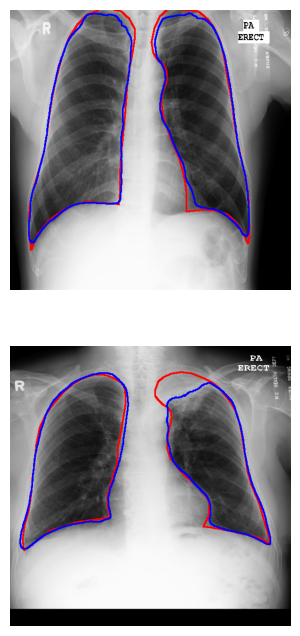

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to your image file
image_path1 = '/kaggle/working/ICEeE/results/MCUCXR_0030_0.png'
image_path2 = '/kaggle/working/ICEeE/results/MCUCXR_0144_1.png'

# Read the image
img1 = mpimg.imread(image_path1)
img2 = mpimg.imread(image_path2)
# Display the image
plt.figure(figsize=[14,8])
# Subplot 1
plt.subplot(211)
plt.imshow(img1)
plt.axis('off')  # Turn off axis labels

# Subplot 2
plt.subplot(212)
plt.imshow(img2)
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming 19 epochs based on the lengths of your metrics
epochs = range(1, 20)  # Adjusted to 19 epochs

# Training metrics values (19 values)
train_loss = [0.5525, 0.5518, 0.2729, 0.1720, 0.1066, 0.1076, 0.0858, 0.0746, 0.0737, 0.0717, 
              0.0689, 0.0613, 0.0678, 0.0614, 0.0650, 0.0585, 0.0536, 0.0509, 0.0513]
train_dice_coef = [0.4475, 0.4482, 0.7271, 0.8280, 0.8934, 0.8924, 0.9142, 0.9254, 0.9263,
                    0.9283, 0.9311, 0.9387, 0.9322, 0.9387, 0.9351, 0.9416, 0.9464, 0.9491, 0.9487]
train_iou = [0.2942, 0.2947, 0.5768, 0.7123, 0.8103, 0.8100, 0.8444, 0.8630, 0.8649,
              0.8679, 0.8729, 0.8855, 0.8749, 0.8856, 0.8805, 0.8915, 0.8995, 0.9042, 0.9036]
train_precision = [0.4274, 0.4280, 0.7944, 0.9228, 0.9562, 0.9665, 0.9745, 0.9763, 0.9815,
                   0.9819, 0.9835, 0.9847, 0.9842, 0.9846, 0.9866, 0.9886, 0.9878, 0.9902, 0.9899]
train_recall = [0.7672, 0.7680, 0.9438, 0.9616, 0.9674, 0.9717, 0.9780, 0.9789, 0.9822,
                 0.9814, 0.9867, 0.9854, 0.9861, 0.9879, 0.9887, 0.9909, 0.9894, 0.9921, 0.9915]

# Validation metrics values (19 values)
val_loss = [0.62701, 0.6801, 0.7968, 0.8482, 0.6481, 0.1089, 0.1041, 0.0977, 0.0988, 
             0.0958, 0.0922, 0.0895, 0.0888, 0.0855, 0.0853, 0.0858, 0.0837, 0.0825, 0.0815]
val_dice_coef = [0.3730, 0.3199, 0.2032, 0.1518, 0.3519, 0.8911, 0.8959, 0.9023, 0.9012, 
                  0.9042, 0.9078, 0.9105, 0.9112, 0.9145, 0.9147, 0.9163, 0.9175, 0.9177, 0.9182]
val_iou = [0.2323, 0.1921, 0.1135, 0.0838, 0.2407, 0.8067, 0.8153, 0.8255, 0.8239, 
            0.8292, 0.8344, 0.8391, 0.8406, 0.8458, 0.8464, 0.8493, 0.8515, 0.8517, 0.8519]
val_precision = [0.3465, 0.2468, 0.0039, 0.8579, 0.9897, 0.9403, 0.9699, 0.9597, 0.9520, 
                 0.9655, 0.9625, 0.9605, 0.9612, 0.9667, 0.9663, 0.9662, 0.9660, 0.9658, 0.9657]
val_recall = [0.9246, 0.0316, 2.9064e-05, 0.0311, 0.2116, 0.9573, 0.9377, 0.9510, 0.9552, 
               0.9473, 0.9529, 0.9535, 0.9522, 0.9515, 0.9493, 0.9495, 0.9490, 0.9488, 0.9486]

# Plotting the metrics
plt.figure(figsize=(18, 12))

# Loss plot
plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.scatter(epochs, train_loss, color='blue')  # Plot points
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.scatter(epochs, val_loss, color='red')  # Plot points
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Dice Coefficient plot
plt.subplot(2, 3, 2)
plt.plot(epochs, train_dice_coef, label='Train Dice Coefficient', color='blue')
plt.scatter(epochs, train_dice_coef, color='blue')  # Plot points
plt.plot(epochs, val_dice_coef, label='Validation Dice Coefficient', color='red')
plt.scatter(epochs, val_dice_coef, color='red')  # Plot points
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

# IoU plot
plt.subplot(2, 3, 3)
plt.plot(epochs, train_iou, label='Train IoU', color='blue')
plt.scatter(epochs, train_iou, color='blue')  # Plot points
plt.plot(epochs, val_iou, label='Validation IoU', color='red')
plt.scatter(epochs, val_iou, color='red')  # Plot points
plt.title('Intersection over Union (IoU)')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

# Precision plot
plt.subplot(2, 3, 4)
plt.plot(epochs, train_precision, label='Train Precision', color='blue')
plt.scatter(epochs, train_precision, color='blue')  # Plot points
plt.plot(epochs, val_precision, label='Validation Precision', color='red')
plt.scatter(epochs, val_precision, color='red')  # Plot points
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall plot
plt.subplot(2, 3, 5)
plt.plot(epochs, train_recall, label='Train Recall', color='blue')
plt.scatter(epochs, train_recall, color='blue')  # Plot points
plt.plot(epochs, val_recall, label='Validation Recall', color='red')
plt.scatter(epochs, val_recall, color='red')  # Plot points
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming 10 epochs based on the lengths of your metrics
epochs = range(1, 11)  # Adjusted to 10 epochs

# Training metrics values (10 values)
train_loss = [0.3673, 0.3538, 0.3044, 0.2845, 0.2464, 0.2034, 0.1992, 0.1918, 0.1859, 
              0.1820]
train_dice_coef = [0.6327, 0.6462, 0.6956, 0.7155, 0.7536, 0.7966, 0.8008, 0.8082, 0.8141,
                    0.8180]
train_iou = [0.4233, 0.4261, 0.5515, 0.5777, 0.6825, 0.7301, 0.7499, 0.7544, 0.7593,
              0.7640]
train_precision = [0.6924, 0.6975, 0.7543, 0.7934, 0.8416, 0.8976, 0.9171, 0.9256, 0.9302,
                   0.9347]
train_recall = [0.8362, 0.8370, 0.8427, 0.8439, 0.8481, 0.8570, 0.8660, 0.8701, 0.8734,
                 0.8745]

# Validation metrics values (10 values)
val_loss = [0.4163, 0.4294, 0.4678, 0.4815, 0.4011, 0.3918, 0.3891, 0.3856, 0.3842, 
             0.3825]
val_dice_coef = [0.5837, 0.5706, 0.5322, 0.5185, 0.5989, 0.6082, 0.6109, 0.6144, 0.6158, 
                  0.6175]
val_iou = [0.3389, 0.3411, 0.3020, 0.2784, 0.3102, 0.3088, 0.3073, 0.3056, 0.3048, 
            0.3041]
val_precision = [0.4292, 0.4326, 0.3071, 0.3846, 0.5371, 0.6474, 0.6799, 0.6991, 0.7017, 
                 0.7046]
val_recall = [0.8202, 0.8231, 0.8887, 0.8926, 0.8923, 0.8954, 0.8959, 0.8978, 0.8991, 
               0.9005]

# Plotting the metrics
plt.figure(figsize=(18, 12))

# Loss plot
plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.scatter(epochs, train_loss, color='blue')  # Plot points
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.scatter(epochs, val_loss, color='red')  # Plot points
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Dice Coefficient plot
plt.subplot(2, 3, 2)
plt.plot(epochs, train_dice_coef, label='Train Dice Coefficient', color='blue')
plt.scatter(epochs, train_dice_coef, color='blue')  # Plot points
plt.plot(epochs, val_dice_coef, label='Validation Dice Coefficient', color='red')
plt.scatter(epochs, val_dice_coef, color='red')  # Plot points
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

# IoU plot
plt.subplot(2, 3, 3)
plt.plot(epochs, train_iou, label='Train IoU', color='blue')
plt.scatter(epochs, train_iou, color='blue')  # Plot points
plt.plot(epochs, val_iou, label='Validation IoU', color='red')
plt.scatter(epochs, val_iou, color='red')  # Plot points
plt.title('Intersection over Union (IoU)')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

# Precision plot
plt.subplot(2, 3, 4)
plt.plot(epochs, train_precision, label='Train Precision', color='blue')
plt.scatter(epochs, train_precision, color='blue')  # Plot points
plt.plot(epochs, val_precision, label='Validation Precision', color='red')
plt.scatter(epochs, val_precision, color='red')  # Plot points
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall plot
plt.subplot(2, 3, 5)
plt.plot(epochs, train_recall, label='Train Recall', color='blue')
plt.scatter(epochs, train_recall, color='blue')  # Plot points
plt.plot(epochs, val_recall, label='Validation Recall', color='red')
plt.scatter(epochs, val_recall, color='red')  # Plot points
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()
